存储的词向量文件
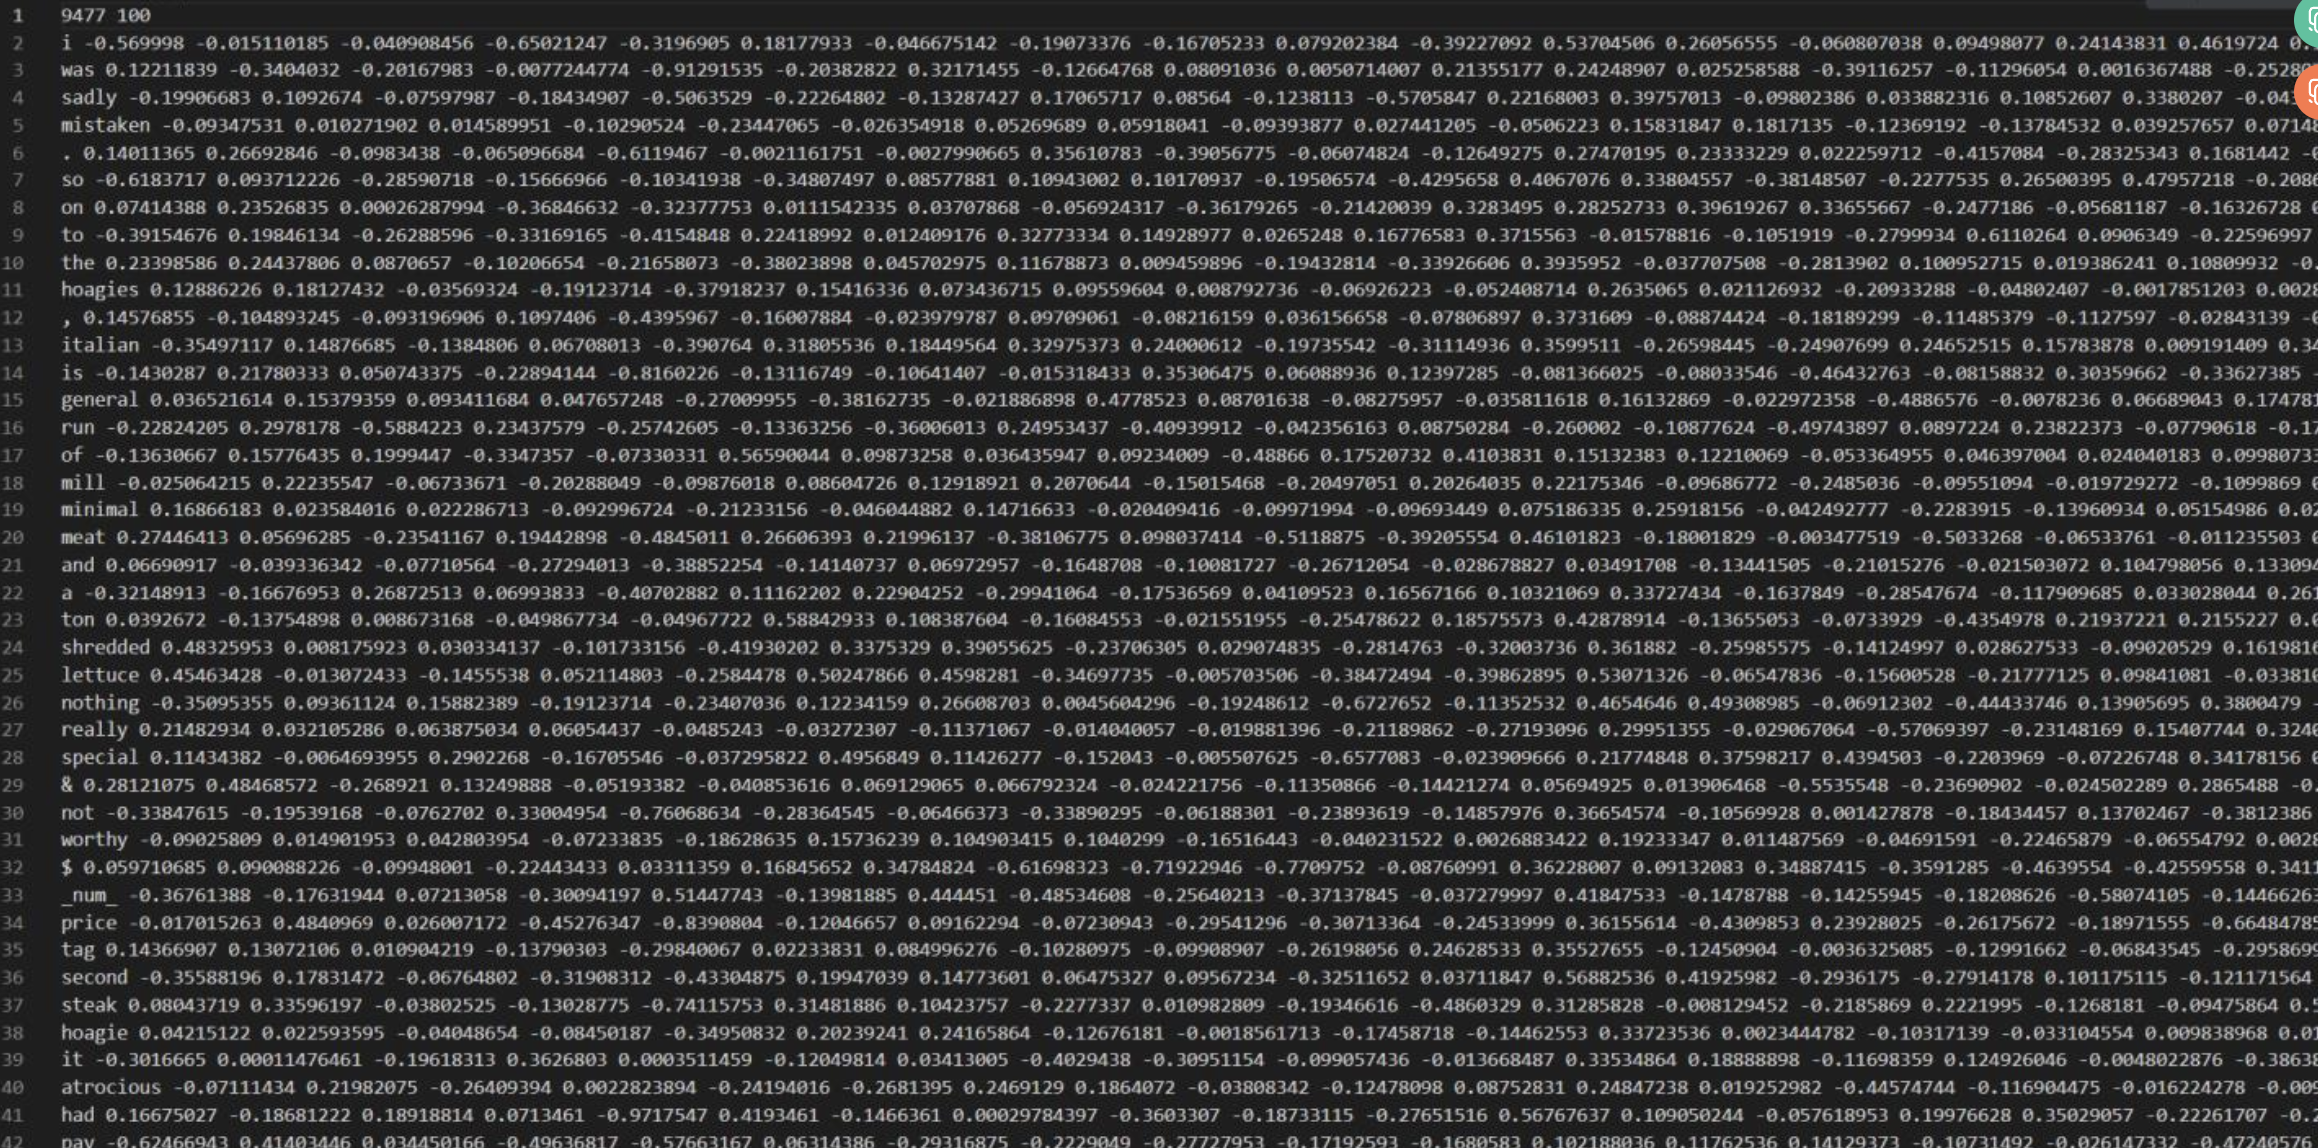

9477个词的词向量，每个词向量是100维
第一个词是i 第二是was

In [ ]:
# %load Skip-gram.py
import torch
from torch.autograd import Variable, backward
import torch.nn as nn
import torch.nn.functional as F
import numpy
from torch.autograd import Variable
import torch
#import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import sys
from collections import deque

#定义模型
class SkipGramModel(nn.Module):
    """
    Skip gram model of word2vec.
    Attributes:
        emb_size:Embedding size.
        emb_dimention:Embedding dimention,typically from 50 to 500
        u_embedding:Embedding for center word.
        v_embedding:Embedding for neibor words.
    """
    def __init__(self,emb_size,emb_dimension):
        """
        Initialize model parameters.

        Apply for two embedding layers.
        Initialize layer weight

        Args:
            emb_size:Embedding size.
            emb_dimention:Embedding dimention,typically from 50 to 500

        Returns:
            None

        """
        super(SkipGramModel,self).__init__()
        self.emb_size=emb_size #词表大小
        self.emb_dimension=emb_dimension #词向量
        
        #维度是emb_size * emb_dimension
        #待训练的中心词词向量矩阵
        self.u_embeddings = nn.Embedding(emb_size,emb_dimension,sparse=True)
        #周围词的词向量矩阵
        self.v_embeddings = nn.Embedding(emb_size,emb_dimension,sparse=True)
        self.init_emb()

    #初始化参数
    def init_emb(self):
        """
        Initialize embedding weight like word2vec.

        The u_embedding is a uniform distribution in [-0.5/em_size,0.5/emb_size],and the elements of v_embedding are zeroes.
        :return:
        None
        """
        initrange=0.5/self.emb_dimension
        #均匀分布初始化所有的参数
        self.u_embeddings.weight.data.uniform_(-initrange,initrange)
        self.v_embeddings.weight.data.uniform_(-0,0)

    #损失函数
    def forward(self,pos_u,pos_v,neg_v):
        """
        Forward process.

        As pytorch designed, all variables must be batch format

        :param pos_u: list of center word ids for positive word pairs
        :param pos_v: list of neibor word ids for positive word pairs
        :param neg_v:list of neibor word ids for negative word pairs
        :return:
        loss of this process, a pytorch variable
        """

        emb_u=self.u_embeddings(pos_u)#正例中心词的词向量
        emb_v = self.v_embeddings(pos_v)#正例周围词的词向量
        
        score = torch.mul(emb_u, emb_v).squeeze()#点乘
        score = torch.sum(score, dim=1)
        score = F.logsigmoid(score)
        
        neg_emb_v = self.v_embeddings(neg_v)
        neg_score = torch.bmm(neg_emb_v, emb_u.unsqueeze(2)).squeeze()#求内积
        #错误的周围词与中心词的内积
        neg_score = F.logsigmoid(-1 * neg_score)
        return -1 * (torch.sum(score) + torch.sum(neg_score))#损失函数越小越好

    #存储词向量
    def save_embedding(self,id2word,file_name,use_cuda):
        """
        Save all embeddings to file

        As this class only record word id


        :param id2word: map from word id to word
        :param file_name: file name
        :param use_cuda:
        :return: None
        """
        #存储u_embeddings：只有转化成numpy的形式才能存储
        if use_cuda:
            #有用cuda，就用cpu
            embedding=self.u_embeddings.weight.cpu().data.numpy()
        else:
            embedding=self.u_embeddings.weight.data.numpy()
        fout=open(file_name,'w',encoding='utf-8')
        fout.write('%d %d\n'%(len(id2word),self.emb_dimension))
        #第一行先存词表大小，和embedding的维度
        for wid,w in id2word.items():
            e=embedding[wid]
            e=' '.join(map(lambda x:str(x),e))
            fout.write('%s %s\n'%(w,e))



#定义数据
class InputData:
    def __init__(self,file_name,min_count):
    # 限制只留下出现 min_count 次以上的词，训练时用了5
       self.input_file_name=file_name
       self.get_words(min_count)
       self.word_pair_catch=deque()
       self.init_sample_table()
       print('Word Count:%d'%len(self.word2id))
       print('Sentence Length:%d'%(self.sentence_length))

    def get_words(self,min_count):
        #把词表里id 和 id对应的词 都存到字典dict里面，还需要存储词频
        self.input_file=open(self.input_file_name,'r',encoding='utf-8')
        self.sentence_length=0
        self.sentence_count=0
        
        word_frequency=dict() #统计词频
        
        for line in self.input_file:
            self.sentence_count+=1 
            line=line.strip().split(' ')
            self.sentence_length+=len(line) #所有句子的单词长度总和
            for w in line:
                try:
                    word_frequency[w]+=1
                except:
                    word_frequency[w]=1

        self.word2id=dict()
        self.id2word=dict()
        wid=0
        self.word_frequency=dict() #和上面的临时变量word_frequency不同
        
        for w,c in word_frequency.items():
            if c<min_count:
                self.sentence_length-=c 
                continue
        #单词 w 的词频不超过5次
        #因为每个句子都会统计一遍单词 w，所以直接减掉c
                
            self.word2id[w]=wid #得到 单词-> id
            self.id2word[wid]=w #得到 id-> 单词
            self.word_frequency[wid]=c #得到 id-> 词频
            wid+=1
        self.word_count=len(self.word2id)

        #构造正例
    def get_batch_pairs(self,batch_size,window_size):
        while len(self.word_pair_catch)<batch_size:
            sentence=self.input_file.readline()

            if sentence is None or sentence=='':
                #self.input_file_name 每一行一个句子的文件
                self.input_file=open(self.input_file_name,'r',encoding='utf-8')
                sentence=self.input_file.readline()
            word_ids=[]
            for word in sentence.strip().split(' '):
                try:
                    word_ids.append(self.word2id[word])
                except:
                    continue
            for i,u in enumerate(word_ids):#索引，数组元素
                for j,v in enumerate(
                    word_ids[max(i-window_size,0):i+window_size]
                ):
                    assert u<self.word_count
                    assert v<self.word_count
                    if i==j:
                        continue
                    self.word_pair_catch.append((u,v))
        batch_pairs=[]
        for _ in range(batch_size):
            batch_pairs.append(self.word_pair_catch.popleft())
        return batch_pairs

    def get_neg_v_neg_sampling(self,pos_word_pair,count):
        neg_v=numpy.random.choice(
            self.sample_table,size=(len(pos_word_pair),count)).tolist()
        return neg_v

    def evaluate_pair_count(self, window_size):
        print(self.sentence_length * (2 * window_size) - (self.sentence_count) * (window_size + 1) * window_size)
        print(self.sentence_count, self.sentence_length, window_size)
        return self.sentence_length * (2 * window_size) - (self.sentence_count) * (window_size + 1) * window_size

    def init_sample_table(self):
        self.sample_table=[]
        sample_table_size=1e8
        pow_frequency=numpy.array(list(self.word_frequency.values()))**0.75
        words_pow=sum(pow_frequency)
        ratio=pow_frequency/words_pow
        count=numpy.round(ratio*sample_table_size)
        for wid,c in enumerate(count):
            self.sample_table+=[wid]*int(c)
        self.sample_table=numpy.array(self.sample_table)



#训练过程
class Word2Vec:
    def __init__(self,
                 input_file_name,
                 output_file_name,
                 emb_dimension=100,
                 batch_size=100,
                 window_size=5,
                 interation=20,#训练集重复训练的次数
                 initial_lr=0.004,
                 min_count=5):  #词表里放至少出现5次的词语
        '''Initilize class parameters.

        Arg:
            input_file_name:Name of a text data from file.Each line is a sentence splited with space.
            output_file_name:Name of the final embedding file.
            emb_dimention:Embedding dimention,typically from 50 to 500.
            bath_size:The count of word pairs for one forward.
            window_size:Max skip length bewteen words.
            interation:Control the multiple training interations.
            initial_lr:initial learning rate.
            min_count:The minimal word frequency,words with lower frequency will br filtered.

        Returns:
            None.
        '''
        self.data=InputData(input_file_name,min_count)
        self.output_file_name=output_file_name
        self.emb_size=len(self.data.word2id)
        self.emb_dimention=emb_dimension
        self.batch_size=batch_size
        self.window_size=window_size
        self.interation=interation
        self.initial_lr=initial_lr
        
        #实例化一个我们刚刚定义的模型
        self.skip_gram_model=SkipGramModel(self.emb_size,self.emb_dimention)
        self.use_cuda=torch.cuda.is_available()
        if self.use_cuda:
            self.skip_gram_model.cuda()
        self.optimizer=optim.SGD(
            self.skip_gram_model.parameters(),lr=self.initial_lr
        )
    def train(self):
        """Multiple training.

        Returns:
            None.
        """
        pair_count=self.data.evaluate_pair_count(self.window_size)
        batch_count=self.interation*pair_count/self.batch_size
        process_bar=tqdm(range(int(batch_count)))
        #tqdm包会显示百分比，训练了百分之多少的步数
        #步数batch_count：整个训练预料需要重复20次，在整个训练集上有多少个训练语料对，每一次训练需要拿batch_size个语料对
        
        #skip.skip_gram_model.save_embedding(
        #   self.data.id2word,'begin_embedding.txt'.self.use_cuda)
        
        for i in process_bar:
            #正负例的pair对
            pos_pairs=self.data.get_batch_pairs(self.batch_size,
                                                self.window_size,)
            neg_v=self.data.get_neg_v_neg_sampling(pos_pairs,5)

            pos_u=[pair[0] for pair in pos_pairs]
            pos_v=[pair[1] for pair in pos_pairs]

            pos_u=Variable(torch.LongTensor(pos_u))
            pos_v = Variable(torch.LongTensor(pos_v))
            neg_v = Variable(torch.LongTensor(neg_v))
            
            if self.use_cuda:
                pos_u=pos_u.cuda()
                pos_v=pos_v.cuda()
                neg_v=neg_v.cuda()
                
            #每一步把梯度清零
            self.optimizer.zero_grad()
            #forward中定义了loss
            loss=self.skip_gram_model.forward(pos_u,pos_v,neg_v)
            #反向传播更新参数
            loss.backward()
            #optimizer用SGD优化器
            self.optimizer.step()

            process_bar.set_description("Loss:%0.8f,lr:%0.6f"%
                                        (loss.data,
                                         self.optimizer.param_groups[0]['lr']))
            if i*self.batch_size%100000==0:
                lr=self.initial_lr*(1.0-1.0*i/batch_count)
                for param_group in self.optimizer.param_groups:
                    param_group['lr']=lr
        self.skip_gram_model.save_embedding(
            self.data.id2word,self.output_file_name,self.use_cuda
        )

if __name__=='__main__':
    w2v=Word2Vec(input_file_name=sys.argv[1],output_file_name=sys.argv[2])
    #输出训练好的词向量数据
    w2v.train()


